In [1]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.regularizers import l2
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import classification_report

In [2]:
import os
os.getcwd()

'C:\\Users\\asma0'

In [3]:
os.chdir(r"C:\Users\asma0\OneDrive\Desktop\audio")


In [4]:
import os
os.getcwd()

'C:\\Users\\asma0\\OneDrive\\Desktop\\audio'

In [5]:
# LOAD IN FILE
x, sr = librosa.load('Actors/Actor_01/03-01-01-01-01-01-01.wav')


In [6]:
# CREATE DIRECTORY OF AUDIO FILES 
audio = "/Users/asma0/OneDrive/Desktop/audio/Actors/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]


['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

In [7]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
emotion = []
gender = []
actor = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [8]:

# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df

,gender,emotion,actor,path
0,male,neutral,1,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...
1,male,neutral,1,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...
2,male,neutral,1,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...
3,male,neutral,1,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...
4,male,calm,1,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...
...,...,...,...,...
1435,female,surprise,24,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...
1436,female,surprise,24,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...
1437,female,surprise,24,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...
1438,female,surprise,24,/Users/asma0/OneDrive/Desktop/audio/Actors/Act...


In [11]:
# ENSURE GENDER,EMOTION, AND ACTOR COLUMN VALUES ARE CORRECT
pd.set_option('display.max_colwidth', None)

audio_df.sample(10)

,gender,emotion,actor,path
1317,female,surprise,22,/Users/asma0/OneDrive/Desktop/audio/Actors/Actor_22/03-01-08-02-01-02-22.wav
752,male,angry,13,/Users/asma0/OneDrive/Desktop/audio/Actors/Actor_13/03-01-05-02-01-01-13.wav
557,female,happy,10,/Users/asma0/OneDrive/Desktop/audio/Actors/Actor_10/03-01-03-02-01-02-10.wav
1005,male,disgust,17,/Users/asma0/OneDrive/Desktop/audio/Actors/Actor_17/03-01-07-01-01-02-17.wav
605,male,calm,11,/Users/asma0/OneDrive/Desktop/audio/Actors/Actor_11/03-01-02-01-01-02-11.wav
307,female,calm,6,/Users/asma0/OneDrive/Desktop/audio/Actors/Actor_06/03-01-02-01-02-02-06.wav
1023,female,neutral,18,/Users/asma0/OneDrive/Desktop/audio/Actors/Actor_18/03-01-01-01-02-02-18.wav
1274,female,happy,22,/Users/asma0/OneDrive/Desktop/audio/Actors/Actor_22/03-01-03-01-02-01-22.wav
1316,female,surprise,22,/Users/asma0/OneDrive/Desktop/audio/Actors/Actor_22/03-01-08-02-01-01-22.wav
583,female,fear,10,/Users/asma0/OneDrive/Desktop/audio/Actors/Actor_10/03-01-06-02-02-02-10.wav


<AxesSubplot:>

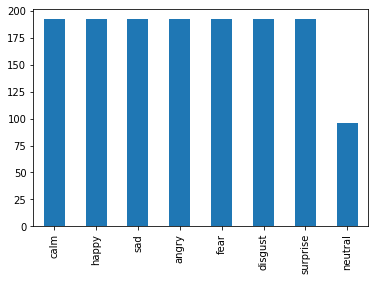

In [12]:

# LOOK AT DISTRIBUTION OF CLASSES
audio_df.emotion.value_counts().plot(kind='bar')

In [13]:

# EXPORT TO CSV


audio_df.to_csv('audio.csv')

In [14]:
## # PLAY AUDIO FILE
path_ = '/Users/asma0/OneDrive/Desktop/audio/Actors/Actor_01/03-01-01-01-01-01-01.wav'

In [15]:
import IPython.display as ipd
ipd.Audio(path_)

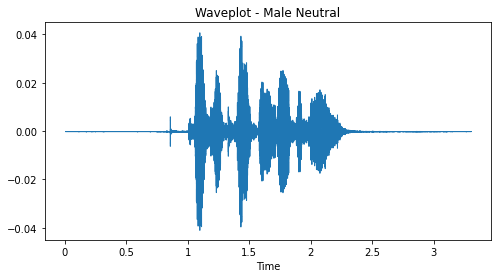

In [16]:

# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Neutral')
plt.savefig('Waveplot_MaleNeutral.png')

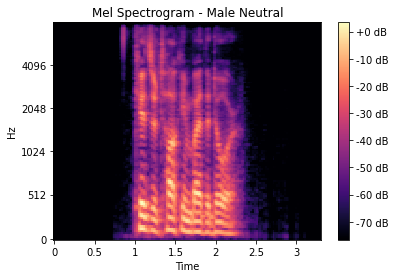

In [17]:

# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Neutral')
plt.savefig('MelSpec_MaleNeutral.png')
plt.colorbar(format='%+2.0f dB');


In [18]:
# LOAD IN FILE
x, sr = librosa.load('Actors/Actor_02/03-01-02-01-01-01-02.wav')

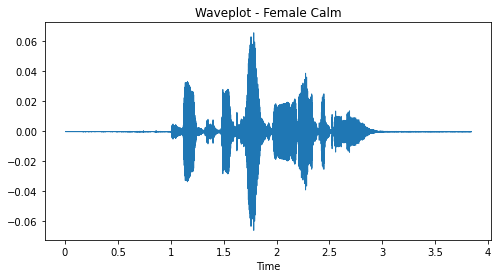

In [19]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Female Calm')
plt.savefig('Waveplot_FemaleCalm.png')


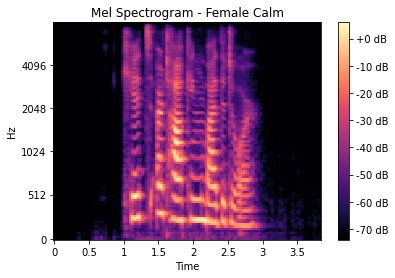

In [20]:

# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Calm')
plt.savefig('MelSpec_FemaleCalm.png')
plt.colorbar(format='%+2.0f dB');

In [21]:

# LOAD FILE
x, sr = librosa.load('Actors/Actor_03/03-01-03-01-01-01-03.wav')

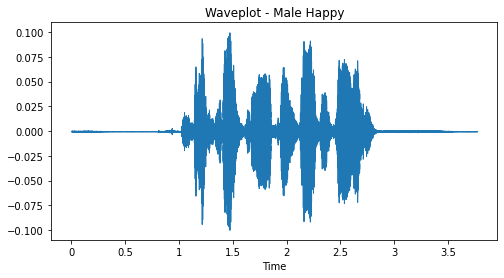

In [22]:

# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Happy')
plt.savefig('Waveplot_MaleHappy.png')


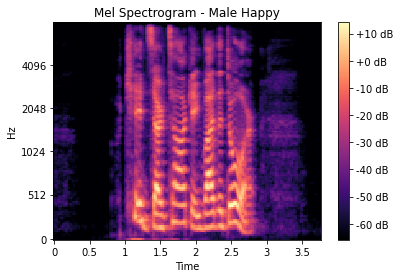

In [23]:

# CREATE LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
x = librosa.power_to_db(x)

librosa.display.specshow(x, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Happy')
plt.savefig('MelSpec_MaleHappy.png')
plt.colorbar(format='%+2.0f dB');


In [24]:

# LOAD FILE
x, sr = librosa.load('Actors/Actor_04/03-01-04-01-01-01-04.wav')


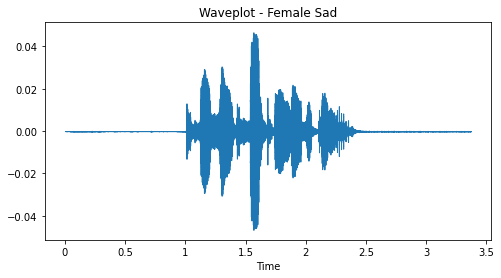

In [25]:


# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Female Sad')
plt.savefig('Waveplot_FemaleSad.png')

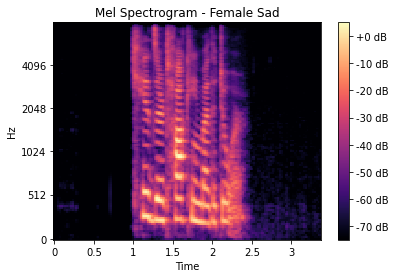

In [26]:


# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Sad');
plt.savefig('MelSpec_FemaleSad.png')
plt.colorbar(format='%+2.0f dB');

In [27]:
# LOAD FILE
x, sr = librosa.load('Actors/Actor_05/03-01-05-01-01-01-05.wav')

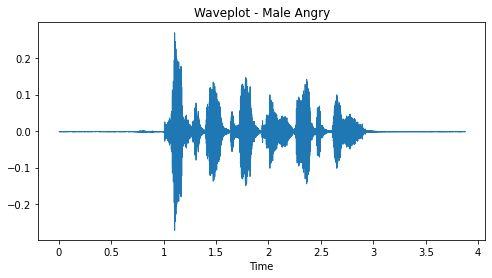

In [28]:

# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Angry')
plt.savefig('Waveplot_MaleAngry.png')


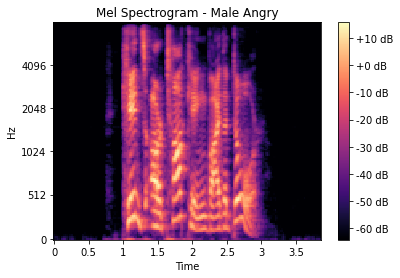

In [29]:

# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Angry');
plt.savefig('MelSpec_MaleAngry.png')
plt.colorbar(format='%+2.0f dB');


In [30]:
# LOAD FILE
x, sr = librosa.load('Actors/Actor_06/03-01-06-01-01-01-06.wav')

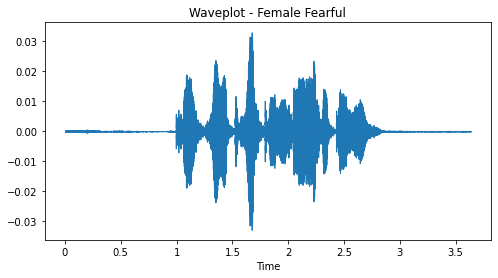

In [31]:


# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Female Fearful')
plt.savefig('Waveplot_FemaleFearful.png')

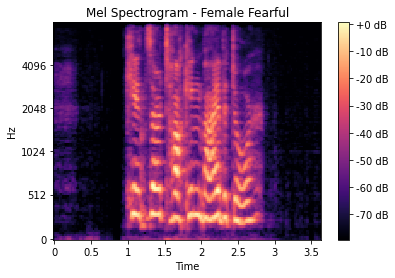

In [32]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Fearful')
plt.savefig('MelSpec_FemaleFearful.png')
plt.colorbar(format='%+2.0f dB');

In [33]:
# LOAD FILE
x, sr = librosa.load('Actors/Actor_07/03-01-07-01-01-01-07.wav')

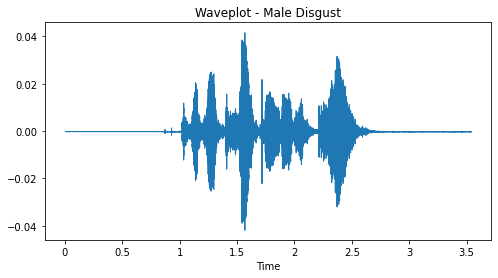

In [34]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Disgust')
plt.savefig('Waveplot_MaleDisgust.png')


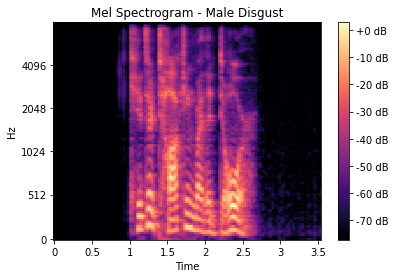

In [35]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Disgust')
plt.savefig('MelSpec_MaleDisgust.png')
plt.colorbar(format='%+2.0f dB');


In [36]:
# LOAD FILE
x, sr = librosa.load('Actors/Actor_08/03-01-08-01-01-01-08.wav')

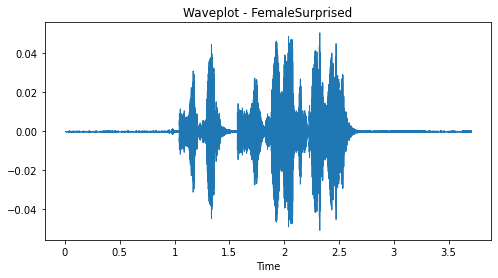

In [37]:

# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - FemaleSurprised')
plt.savefig('Waveplot_FemaleSurprised.png')

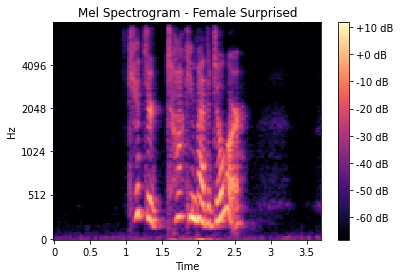

In [38]:

# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Surprised')
plt.savefig('MelSpec_FemaleSurprised.png')
plt.colorbar(format='%+2.0f dB');


In [39]:

# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
        
    # Mel-frequency cepstral coefficients (MFCCs)
#     mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#     mfcc=np.mean(mfcc,axis=0)
    
    # compute chroma energy (pertains to 12 different pitch classes)
#     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#     chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
#     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#     contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df))
df.head()


1440


,mel_spectrogram
0,"[-76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.385826, -76.14387, -75.59903, -75.83965, -75.39555, -75.80363, -75.75495, -75.479576, -74.90699, -73.19491, -71.95893, -67.256256, -66.7253, -70.19872, -72.43059, -72.19525, -73.0599, -73.42753, -74.021675, -72.47083, -70.02688, -70.72411, -71.79504, -64.80341, -46.808846, -41.033237, -42.1165, -44.491566, -41.499184, -35.996136, -33.451782, -33.01107, -33.391262, -34.381775, -34.16136, -36.274837, -41.017044, -43.187458, -44.303783, -43.356293, -41.922813, -38.182495, -36.49884, -34.244164, -33.821125, -33.816025, -34.37284, -36.781616, -42.55402, -48.30717, -50.684418, -46.123383, -39.248436, -39.674007, -42.04363, -42.64738, -43.153008, -42.136765, -39.60632, -36.050503, -34.323284, -34.15922, -34.64027, -34.682194, -32.951748, -32.30794, -34.025593, -38.50067, -43.355003, -46.00169, -45.9331, -45.320827, -46.64157, -46.531757, -41.633873, -38.821774, -38.928257, -39.01654, -40.20745, -42.15922, -43.356064, ...]"
1,"[-75.55664, -75.53999, -75.61388, -74.98714, -75.1306, -75.23204, -75.62536, -75.7206, -75.7206, -75.7206, -75.7206, -75.7206, -75.614784, -75.03667, -74.84546, -75.33984, -75.55745, -75.719894, -75.7206, -75.7206, -75.63347, -75.36134, -75.02477, -75.04742, -75.39334, -73.23509, -66.15548, -66.953835, -72.06528, -62.148136, -56.32514, -54.71821, -59.424583, -65.52312, -71.60172, -73.20834, -73.958275, -75.119, -75.487335, -73.15222, -70.73789, -71.21643, -72.51486, -58.203148, -47.401176, -43.75829, -43.790718, -45.385456, -44.533802, -39.824497, -35.99376, -34.31282, -32.9918, -32.865875, -33.462223, -36.381477, -41.68843, -44.88684, -45.844296, -45.321213, -44.59171, -42.282993, -39.167015, -36.19472, -34.43799, -34.072094, -34.486214, -34.47429, -34.608253, -37.379242, -43.368507, -47.869457, -50.63121, -52.332687, -42.30034, -37.942276, -38.961937, -40.39976, -41.49765, -39.725094, -38.02865, -38.612564, -37.08277, -32.562096, -30.722288, -31.068161, -30.673588, -30.065767, -31.851543, -37.462036, -43.515854, -46.420216, -45.0026, -43.646744, -45.437737, -47.354923, -43.83682, -40.871075, -39.60246, -38.144176, ...]"
2,"[-75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.151695, -75.128174, -75.15176, -74.96018, -74.0734, -74.17021, -74.58771, -75.136345, -75.14233, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.15176, -75.0869, -74.05024, -73.52307, -74.65709, -74.11767, -73.56357, -72.46165, -72.90738, -49.99199, -40.58966, -37.65544, -36.36051, -34.71849, -32.372257, -31.12474, -30.72461, -31.42056, -31.289776, -30.474234, -29.17016, -28.635437, -28.551722, -29.487131, -31.136003, -33.27878, -37.73821, -42.117035, -45.12945, -44.771008, -41.838825, -41.01416, -40.91587, -40.911926, -42.274532, -41.513756, -38.371117, -36.679897, -37.14012, -36.85559, -37.126945, -37.777847, -38.964848, -40.907753, -41.579056, -42.29705, -42.41391, -41.356594, -39.57682, -40.59594, -41.633297, -38.067825, -33.40461, -33.516205, -34.27759, -37.989788, -44.00755, -40.600605, -36.581715, -35.711876, -35.0026, -34.958927, -35.31869, -36.245697, -39.09258, -41.657578, ...]"
3,"[-75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.23564, -75.15326, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -75.26951, -74.425125, -73.95621, -73.681915, -73.31475, -72.81902, -72.18797, -72.687416, -62.717197, -42.69008, -36.684757, -33.682865, -32.019287, -30.3

In [40]:


# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)


In [41]:


# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)

In [42]:


# CHECK TOP 5 ROWS
df_combined.head()

,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,male,neutral,1,-76.385826,-76.385826,-76.385826,-76.385826,-76.385826,-76.385826,-76.385826,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,male,neutral,1,-75.556641,-75.539993,-75.613876,-74.987137,-75.130600,-75.232040,-75.625359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male,neutral,1,-75.151756,-75.151756,-75.151756,-75.151756,-75.151756,-75.151756,-75.151756,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male,neutral,1,-75.269508,-75.269508,-75.269508,-75.269508,-75.269508,-75.269508,-75.269508,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male,calm,1,-80.147842,-80.147842,-80.147842,-80.147842,-80.147842,-80.147842,-80.147842,...,-80.147842,-80.147842,-80.147842,-80.147842,-80.147842,-80.147842,-80.147842,-80.147842,-80.147842,-80.147842


# Prepping Data for Modeling

In [43]:
from sklearn.model_selection import train_test_split


# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['emotion','gender','actor']])

In [44]:

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)


(1152, 259)


In [45]:
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)

(288, 259)


# Data Preprocessing

In [47]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [48]:

# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [49]:

# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])


[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


C:\Users\asma0\anaconda3\envs\bean\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:

print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [58]:

# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

X_train.shape


(1152, 259, 1, 1)

In [59]:
## Base model

In [60]:
X_train.shape

(1152, 259, 1, 1)

In [61]:

X_test.shape

(288, 259, 1, 1)

In [62]:
import numpy as np
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)


0.03819444444444445

In [64]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='sigmoid'))
opt = tf.keras.optimizers.legacy.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 250, 64)           704       
                                                                 
 conv1d_7 (Conv1D)           (None, 241, 128)          82048     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 30, 128)          0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 30, 128)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 21, 128)           163968    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 128)           0         
 1D)                                                  

C:\Users\asma0\anaconda3\envs\bean\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [66]:
import tensorflow.keras as keras

# FIT MODEL AND USE CHECKPOINT TO SAVE BEST MODEL
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', save_freq=1, save_weights_only=True)

model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test),callbacks=[checkpoint])


Epoch 1/40


 1/36 [..............................] - ETA: 1s - loss: 0.9181 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.9589 - accuracy: 0.6719WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 0.9728 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 1.0035 - accuracy: 0.6719WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 1.0248 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 1.0534 - accuracy: 0.6510WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 1.0855 - accuracy: 0.6384WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 1.1006 - accuracy: 0.6211WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 1.1072 - accuracy: 0.6111WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 1.1067 - accuracy: 0.6062WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 1.1441 - accuracy: 0.5909WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 1.1596 - accuracy: 0.5781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 1.1562 - accuracy: 0.5817WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 1.1431 - accuracy: 0.5893WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 1.1477 - accuracy: 0.5896WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 1.1666 - accuracy: 0.5840WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 1s - loss: 1.1784 - accuracy: 0.5790WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 1s - loss: 1.1649 - accuracy: 0.5833WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 1.1686 - accuracy: 0.5773WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 1.1738 - accuracy: 0.5797WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 1.1589 - accuracy: 0.5838WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 1.1748 - accuracy: 0.5788WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 1.1731 - accuracy: 0.5781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 1.1763 - accuracy: 0.5800WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 1.1710 - accuracy: 0.5793WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.1653 - accuracy: 0.5822WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 1.1736 - accuracy: 0.5770WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.1742 - accuracy: 0.5754WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 1.1652 - accuracy: 0.5781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 1.1690 - accuracy: 0.5756WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.1723 - accuracy: 0.5752WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 1.1807 - accuracy: 0.5720WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 1.1868 - accuracy: 0.5689WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 1.1850 - accuracy: 0.5714WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 60ms/step - loss: 1.1812 - accuracy: 0.5703 - val_loss: 1.3340 - val_accuracy: 0.5382
Epoch 2/40


 1/36 [..............................] - ETA: 1s - loss: 1.0070 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 1.1015 - accuracy: 0.5781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 0.9932 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 1.0980 - accuracy: 0.5781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 1.0762 - accuracy: 0.5688WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 1.0590 - accuracy: 0.5990WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 1.0605 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 1.0677 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 1.0809 - accuracy: 0.5799WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 1.0809 - accuracy: 0.5750WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 1.0982 - accuracy: 0.5682WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 1.1112 - accuracy: 0.5625WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 1.1140 - accuracy: 0.5697WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 1.1130 - accuracy: 0.5737WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 1.1116 - accuracy: 0.5813WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 1s - loss: 1.1013 - accuracy: 0.5882WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 1.0994 - accuracy: 0.5855WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 1.1006 - accuracy: 0.5844WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 1.1012 - accuracy: 0.5848WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 1.1033 - accuracy: 0.5883WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 1.0992 - accuracy: 0.5898WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 1.1012 - accuracy: 0.5901WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.0988 - accuracy: 0.5926WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 1.1048 - accuracy: 0.5893WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 1.1145 - accuracy: 0.5885WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.1214 - accuracy: 0.5840WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 1.1292 - accuracy: 0.5824WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 1.1251 - accuracy: 0.5827WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 1.1331 - accuracy: 0.5821WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 55ms/step - loss: 1.1367 - accuracy: 0.5790 - val_loss: 1.3609 - val_accuracy: 0.5243
Epoch 3/40


 1/36 [..............................] - ETA: 1s - loss: 1.2654 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 1.3806 - accuracy: 0.5312WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 1.2268 - accuracy: 0.5703WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 1.2318 - accuracy: 0.5500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 1.2507 - accuracy: 0.5312WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 1.2573 - accuracy: 0.5268WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 1.2510 - accuracy: 0.5195WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 1.2025 - accuracy: 0.5486WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 1.1928 - accuracy: 0.5531WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 1.2089 - accuracy: 0.5511WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 1.2075 - accuracy: 0.5521WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 1.2039 - accuracy: 0.5457WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 1.2096 - accuracy: 0.5357WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 1.1867 - accuracy: 0.5458WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 1.2051 - accuracy: 0.5410WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 1.1981 - accuracy: 0.5478WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 1s - loss: 1.1918 - accuracy: 0.5521WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 1.1884 - accuracy: 0.5543WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 1.1957 - accuracy: 0.5506WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 1.1865 - accuracy: 0.5554WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 1.1864 - accuracy: 0.5571WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 1.1866 - accuracy: 0.5573WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 1.1888 - accuracy: 0.5500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 1.1837 - accuracy: 0.5553WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.1839 - accuracy: 0.5532WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 1.1837 - accuracy: 0.5558WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.1846 - accuracy: 0.5571WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 1.1748 - accuracy: 0.5594WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 1.1664 - accuracy: 0.5615WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.1649 - accuracy: 0.5635WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 1.1618 - accuracy: 0.5634WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 1.1590 - accuracy: 0.5661WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 58ms/step - loss: 1.1624 - accuracy: 0.5668 - val_loss: 1.3407 - val_accuracy: 0.5694
Epoch 4/40


 1/36 [..............................] - ETA: 1s - loss: 1.0832 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.9428 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 1.0666 - accuracy: 0.6354WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 1.0664 - accuracy: 0.6328WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 1.0232 - accuracy: 0.6406WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 1.0807 - accuracy: 0.6205WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 1.0869 - accuracy: 0.6111WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 1.0742 - accuracy: 0.6125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 1.0655 - accuracy: 0.6108WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 1.0943 - accuracy: 0.5990WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 1.1081 - accuracy: 0.5982WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 1.1023 - accuracy: 0.6042WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 1.1089 - accuracy: 0.6035WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 1.1197 - accuracy: 0.5974WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 1.1261 - accuracy: 0.5972WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 1.1371 - accuracy: 0.5875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 1.1297 - accuracy: 0.5893WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 1.1240 - accuracy: 0.5910WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 1.1304 - accuracy: 0.5911WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 1.1251 - accuracy: 0.5913WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 1.1265 - accuracy: 0.5913WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.1299 - accuracy: 0.5891WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 1.1303 - accuracy: 0.5904WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.1155 - accuracy: 0.5970WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 1.1202 - accuracy: 0.5958WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 1.1227 - accuracy: 0.5948WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.1193 - accuracy: 0.5947WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 1.1114 - accuracy: 0.6004WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 1.1125 - accuracy: 0.6002WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 1.1048 - accuracy: 0.6027WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 59ms/step - loss: 1.1052 - accuracy: 0.6007 - val_loss: 1.3378 - val_accuracy: 0.5625
Epoch 5/40


 1/36 [..............................] - ETA: 1s - loss: 1.0732 - accuracy: 0.5625WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 1.0427 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 1.0766 - accuracy: 0.5833WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 1.1484 - accuracy: 0.5703WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 1.1015 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 1.0655 - accuracy: 0.5990WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 1.0895 - accuracy: 0.5859WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 1.0978 - accuracy: 0.5868WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 1.0835 - accuracy: 0.5969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 1.0817 - accuracy: 0.5994WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 1.0748 - accuracy: 0.6042WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 1.0890 - accuracy: 0.6034WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 1.0910 - accuracy: 0.6094WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 1.0931 - accuracy: 0.6125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 1.0990 - accuracy: 0.6133WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 1s - loss: 1.0975 - accuracy: 0.6121WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 1.0917 - accuracy: 0.6146WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 1.1003 - accuracy: 0.6118WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 1.1121 - accuracy: 0.6047WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 1.1002 - accuracy: 0.6086WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 1.0902 - accuracy: 0.6122WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 1.0962 - accuracy: 0.6087WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 1.1142 - accuracy: 0.6055WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 1.1136 - accuracy: 0.6062WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 1.1181 - accuracy: 0.6058WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.1213 - accuracy: 0.6030WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.1363 - accuracy: 0.5959WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 1.1345 - accuracy: 0.5969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 1.1319 - accuracy: 0.5978WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.1351 - accuracy: 0.5957WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 1.1263 - accuracy: 0.6004WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 1.1210 - accuracy: 0.6020WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 1.1319 - accuracy: 0.5991WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 58ms/step - loss: 1.1387 - accuracy: 0.5972 - val_loss: 1.3218 - val_accuracy: 0.5382
Epoch 6/40


 1/36 [..............................] - ETA: 1s - loss: 1.1171 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 1.0796 - accuracy: 0.6094WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 1.1325 - accuracy: 0.6042WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 1.0910 - accuracy: 0.6172WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 1.0445 - accuracy: 0.6313WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 1.0679 - accuracy: 0.6198WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 1.0747 - accuracy: 0.6205WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 1.0629 - accuracy: 0.6172WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 1.0586 - accuracy: 0.6181WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 1.0702 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 1.0846 - accuracy: 0.6165WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 1.0917 - accuracy: 0.6082WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 1.0856 - accuracy: 0.6062WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 1.0850 - accuracy: 0.5993WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 1.0809 - accuracy: 0.6059WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 1.1025 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 1.1295 - accuracy: 0.5878WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 1.1215 - accuracy: 0.5866WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 1.1281 - accuracy: 0.5829WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 1.1355 - accuracy: 0.5781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 1.1381 - accuracy: 0.5763WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.1341 - accuracy: 0.5833WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.1197 - accuracy: 0.5927WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 1.1253 - accuracy: 0.5857WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.1182 - accuracy: 0.5869WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 1.1141 - accuracy: 0.5890WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 1.1159 - accuracy: 0.5901WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 1.1107 - accuracy: 0.5946WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 54ms/step - loss: 1.1082 - accuracy: 0.5955 - val_loss: 1.3171 - val_accuracy: 0.5625
Epoch 7/40


 1/36 [..............................] - ETA: 1s - loss: 1.0639 - accuracy: 0.5625WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 1.0061 - accuracy: 0.5781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.9345 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.9595 - accuracy: 0.6625WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.9770 - accuracy: 0.6510WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.9933 - accuracy: 0.6406WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 1.0211 - accuracy: 0.6313WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 1.0414 - accuracy: 0.6165WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 1.0341 - accuracy: 0.6172WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 1.0651 - accuracy: 0.6010WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 1.0756 - accuracy: 0.5982WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 1.0935 - accuracy: 0.5859WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 1.1052 - accuracy: 0.5809WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 1.1056 - accuracy: 0.5851WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 1.0959 - accuracy: 0.5888WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 1.0879 - accuracy: 0.5982WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 1.0852 - accuracy: 0.6033WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 1.1060 - accuracy: 0.5962WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.0954 - accuracy: 0.6030WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.0970 - accuracy: 0.6013WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 1.0966 - accuracy: 0.6021WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 1.1011 - accuracy: 0.6028WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.1036 - accuracy: 0.6045WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 1.0990 - accuracy: 0.6051WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 1.1036 - accuracy: 0.6054WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 53ms/step - loss: 1.0989 - accuracy: 0.6076 - val_loss: 1.3310 - val_accuracy: 0.5382
Epoch 8/40


 1/36 [..............................] - ETA: 1s - loss: 1.2755 - accuracy: 0.5000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 1.2566 - accuracy: 0.5000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 1.1575 - accuracy: 0.5417WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 1.1137 - accuracy: 0.5859WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 1.1086 - accuracy: 0.5875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 1.0714 - accuracy: 0.6094WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 1.0887 - accuracy: 0.6027WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 1.0845 - accuracy: 0.6055WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 1.0926 - accuracy: 0.5972WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 1.0849 - accuracy: 0.5994WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 1.0988 - accuracy: 0.5913WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 1.0839 - accuracy: 0.6027WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 1.0818 - accuracy: 0.6042WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 1.0860 - accuracy: 0.6035WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 1s - loss: 1.0781 - accuracy: 0.6011WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 1.0647 - accuracy: 0.6128WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 1.0553 - accuracy: 0.6217WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 1.0448 - accuracy: 0.6265WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 1.0334 - accuracy: 0.6307WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 1.0430 - accuracy: 0.6263WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 1.0511 - accuracy: 0.6286WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.0479 - accuracy: 0.6296WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 1.0586 - accuracy: 0.6283WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.0642 - accuracy: 0.6228WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 1.0564 - accuracy: 0.6240WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.0554 - accuracy: 0.6201WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 1.0581 - accuracy: 0.6184WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 1.0577 - accuracy: 0.6195WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 55ms/step - loss: 1.0619 - accuracy: 0.6189 - val_loss: 1.3073 - val_accuracy: 0.5382
Epoch 9/40


 1/36 [..............................] - ETA: 1s - loss: 1.1150 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 1.0422 - accuracy: 0.6406WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 1.0264 - accuracy: 0.6328WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 1.0478 - accuracy: 0.6146WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 1.0500 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 1.0487 - accuracy: 0.6215WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 1.0231 - accuracy: 0.6344WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 1.0325 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 1.0152 - accuracy: 0.6328WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 1.0218 - accuracy: 0.6274WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 1.0231 - accuracy: 0.6317WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 1.0345 - accuracy: 0.6271WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 1.0520 - accuracy: 0.6152WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 1.0491 - accuracy: 0.6176WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 1.0613 - accuracy: 0.6102WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 1.0527 - accuracy: 0.6141WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 1.0721 - accuracy: 0.6009WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 1.0689 - accuracy: 0.6094WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 1.0811 - accuracy: 0.6070WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 1.0788 - accuracy: 0.6071WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.0838 - accuracy: 0.6067WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 1.0702 - accuracy: 0.6109WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 1.0654 - accuracy: 0.6146WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 1.0726 - accuracy: 0.6098WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 54ms/step - loss: 1.0739 - accuracy: 0.6094 - val_loss: 1.2997 - val_accuracy: 0.5694
Epoch 10/40


 1/36 [..............................] - ETA: 1s - loss: 1.0342 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 1.1806 - accuracy: 0.6406WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 1.1058 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 1.1099 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 1.1099 - accuracy: 0.6295WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 1.1236 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 1.1049 - accuracy: 0.6344WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 1.0879 - accuracy: 0.6354WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 1.0659 - accuracy: 0.6362WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 0s - loss: 1.0473 - accuracy: 0.6465WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 1.0447 - accuracy: 0.6471WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 1.0481 - accuracy: 0.6382WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 1.0506 - accuracy: 0.6324WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 1.0636 - accuracy: 0.6207WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 1.0679 - accuracy: 0.6155WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 1.0650 - accuracy: 0.6159WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 1.0557 - accuracy: 0.6237WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.0559 - accuracy: 0.6227WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 1.0583 - accuracy: 0.6205WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.0495 - accuracy: 0.6218WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 1.0464 - accuracy: 0.6219WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 1.0437 - accuracy: 0.6230WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.0505 - accuracy: 0.6191WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 1.0548 - accuracy: 0.6174WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 1.0572 - accuracy: 0.6186WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 1.0549 - accuracy: 0.6196WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 53ms/step - loss: 1.0634 - accuracy: 0.6137 - val_loss: 1.3047 - val_accuracy: 0.5347
Epoch 11/40


 1/36 [..............................] - ETA: 1s - loss: 1.0658 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 1.1249 - accuracy: 0.5625WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 1.0443 - accuracy: 0.6094WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 1.0441 - accuracy: 0.6146WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 1.0482 - accuracy: 0.6205WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 1.0077 - accuracy: 0.6523WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 1.0208 - accuracy: 0.6528WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 1.0163 - accuracy: 0.6531WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 1.0130 - accuracy: 0.6477WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 1.0134 - accuracy: 0.6458WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 1.0161 - accuracy: 0.6418WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 1.0088 - accuracy: 0.6473WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.9956 - accuracy: 0.6521WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 0.9860 - accuracy: 0.6543WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.9936 - accuracy: 0.6471WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 1.0076 - accuracy: 0.6372WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 1.0228 - accuracy: 0.6365WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 1.0240 - accuracy: 0.6359WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 1.0244 - accuracy: 0.6378WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 1.0223 - accuracy: 0.6367WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 1.0270 - accuracy: 0.6350WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 1.0344 - accuracy: 0.6310WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.0275 - accuracy: 0.6319WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 1.0358 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.0424 - accuracy: 0.6207WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 1.0386 - accuracy: 0.6219WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 1.0343 - accuracy: 0.6240WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.0324 - accuracy: 0.6260WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 1.0407 - accuracy: 0.6241WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.6232WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 58ms/step - loss: 1.0436 - accuracy: 0.6207 - val_loss: 1.2907 - val_accuracy: 0.5833
Epoch 12/40


 1/36 [..............................] - ETA: 1s - loss: 1.1252 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 1.1076 - accuracy: 0.6094WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 1.0906 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 1.0925 - accuracy: 0.5750WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 1.0689 - accuracy: 0.5990WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 1.0742 - accuracy: 0.6027WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 1.0831 - accuracy: 0.6016WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 1.0778 - accuracy: 0.5969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 1.0675 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 1.0682 - accuracy: 0.6010WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 1.0409 - accuracy: 0.6083WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 1.0259 - accuracy: 0.6176WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 1.0210 - accuracy: 0.6233WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 1.0005 - accuracy: 0.6332WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.9946 - accuracy: 0.6359WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.9917 - accuracy: 0.6414WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 1.0041 - accuracy: 0.6427WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.9976 - accuracy: 0.6438WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.9938 - accuracy: 0.6418WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.9941 - accuracy: 0.6412WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.0073 - accuracy: 0.6315WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 1.0134 - accuracy: 0.6292WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.0305 - accuracy: 0.6240WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 1.0309 - accuracy: 0.6241WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 53ms/step - loss: 1.0309 - accuracy: 0.6250 - val_loss: 1.3070 - val_accuracy: 0.5486
Epoch 13/40


 1/36 [..............................] - ETA: 1s - loss: 0.8843 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 0.9824 - accuracy: 0.6458WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 1.0163 - accuracy: 0.6375WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.9839 - accuracy: 0.6429WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.9746 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.9530 - accuracy: 0.6676WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.9949 - accuracy: 0.6466WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 1.0020 - accuracy: 0.6417WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 1.0077 - accuracy: 0.6397WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 1.0055 - accuracy: 0.6372WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 1.0202 - accuracy: 0.6332WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 1.0103 - accuracy: 0.6384WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.9994 - accuracy: 0.6435WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.9890 - accuracy: 0.6427WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.9988 - accuracy: 0.6380WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 1.0095 - accuracy: 0.6338WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 1.0196 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.0247 - accuracy: 0.6215WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 1.0161 - accuracy: 0.6261WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.0263 - accuracy: 0.6207WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 1.0269 - accuracy: 0.6190WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.0199 - accuracy: 0.6221WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 1.0208 - accuracy: 0.6204WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 1.0204 - accuracy: 0.6214WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 53ms/step - loss: 1.0270 - accuracy: 0.6189 - val_loss: 1.2852 - val_accuracy: 0.5312
Epoch 14/40


 1/36 [..............................] - ETA: 1s - loss: 0.7354 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 0.7538 - accuracy: 0.7708WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.7852 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.8360 - accuracy: 0.7250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.8419 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.8703 - accuracy: 0.6992WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.8785 - accuracy: 0.6944WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.9022 - accuracy: 0.6790WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.8969 - accuracy: 0.6771WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.8882 - accuracy: 0.6853WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 0.8931 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.9334 - accuracy: 0.6684WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.9407 - accuracy: 0.6661WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.9614 - accuracy: 0.6577WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.9737 - accuracy: 0.6603WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.9766 - accuracy: 0.6612WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.9766 - accuracy: 0.6609WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.9673 - accuracy: 0.6649WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.9631 - accuracy: 0.6683WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.9683 - accuracy: 0.6686WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.9659 - accuracy: 0.6700WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 52ms/step - loss: 0.9695 - accuracy: 0.6701 - val_loss: 1.3797 - val_accuracy: 0.5521
Epoch 15/40


 1/36 [..............................] - ETA: 1s - loss: 0.8041 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.9625 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.9362 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.9771 - accuracy: 0.6146WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.9877 - accuracy: 0.6055WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 1.0512 - accuracy: 0.5781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 1.0782 - accuracy: 0.5729WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 1.0664 - accuracy: 0.5781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 0s - loss: 1.0446 - accuracy: 0.5859WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 1.0572 - accuracy: 0.5799WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 1.0523 - accuracy: 0.5859WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 1.0503 - accuracy: 0.5923WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 1.0568 - accuracy: 0.5951WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 1.0526 - accuracy: 0.5987WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.0692 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.0580 - accuracy: 0.6002WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 1.0580 - accuracy: 0.5979WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 1.0571 - accuracy: 0.5988WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 1.0538 - accuracy: 0.6023WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 1.0503 - accuracy: 0.6039WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 52ms/step - loss: 1.0511 - accuracy: 0.6050 - val_loss: 1.3163 - val_accuracy: 0.5590
Epoch 16/40


 1/36 [..............................] - ETA: 1s - loss: 0.7712 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.9774 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 1.0399 - accuracy: 0.6484WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.9924 - accuracy: 0.6687WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 1.0550 - accuracy: 0.6384WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 1.0509 - accuracy: 0.6319WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 1.0539 - accuracy: 0.6136WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 1.0198 - accuracy: 0.6178WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 1.0265 - accuracy: 0.6161WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 0s - loss: 1.0254 - accuracy: 0.6270WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 1.0262 - accuracy: 0.6324WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 1.0365 - accuracy: 0.6283WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 1.0312 - accuracy: 0.6280WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 1.0283 - accuracy: 0.6277WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 1.0163 - accuracy: 0.6325WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 1.0143 - accuracy: 0.6310WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 1.0209 - accuracy: 0.6273WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 1.0082 - accuracy: 0.6336WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.9986 - accuracy: 0.6411WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 1.0017 - accuracy: 0.6396WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 1.0058 - accuracy: 0.6397WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 52ms/step - loss: 1.0102 - accuracy: 0.6345 - val_loss: 1.2910 - val_accuracy: 0.5938
Epoch 17/40


 1/36 [..............................] - ETA: 1s - loss: 0.7813 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.7805 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.9099 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.9168 - accuracy: 0.6812WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.9255 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.9169 - accuracy: 0.6914WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.9481 - accuracy: 0.6687WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.9381 - accuracy: 0.6745WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.9633 - accuracy: 0.6652WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 0s - loss: 0.9514 - accuracy: 0.6758WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.9737 - accuracy: 0.6684WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.9739 - accuracy: 0.6687WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.9924 - accuracy: 0.6619WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.9925 - accuracy: 0.6630WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.9950 - accuracy: 0.6589WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.9867 - accuracy: 0.6612WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.9864 - accuracy: 0.6647WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.9777 - accuracy: 0.6701WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.9796 - accuracy: 0.6724WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.9857 - accuracy: 0.6698WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.9976 - accuracy: 0.6611WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.9927 - accuracy: 0.6648WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.9977 - accuracy: 0.6616WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 53ms/step - loss: 0.9997 - accuracy: 0.6606 - val_loss: 1.2973 - val_accuracy: 0.5625
Epoch 18/40


 1/36 [..............................] - ETA: 1s - loss: 0.8585 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.8561 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 0.8896 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.8830 - accuracy: 0.6625WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.9432 - accuracy: 0.6473WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.9058 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.9133 - accuracy: 0.6648WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.9262 - accuracy: 0.6611WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.9261 - accuracy: 0.6646WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.9207 - accuracy: 0.6636WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.9191 - accuracy: 0.6701WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.9104 - accuracy: 0.6750WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.9180 - accuracy: 0.6818WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.9177 - accuracy: 0.6836WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.9151 - accuracy: 0.6851WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.9199 - accuracy: 0.6817WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.9087 - accuracy: 0.6886WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.9150 - accuracy: 0.6854WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.9150 - accuracy: 0.6815WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.9205 - accuracy: 0.6790WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.9249 - accuracy: 0.6768WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 52ms/step - loss: 0.9330 - accuracy: 0.6745 - val_loss: 1.2903 - val_accuracy: 0.5764
Epoch 19/40


 1/36 [..............................] - ETA: 1s - loss: 0.9828 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 1.0191 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.9833 - accuracy: 0.6125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.9832 - accuracy: 0.6302WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.9756 - accuracy: 0.6406WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.9761 - accuracy: 0.6424WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.9874 - accuracy: 0.6477WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.9840 - accuracy: 0.6442WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.9581 - accuracy: 0.6604WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 0s - loss: 0.9732 - accuracy: 0.6641WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.9676 - accuracy: 0.6632WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.9638 - accuracy: 0.6703WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.9549 - accuracy: 0.6690WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.9466 - accuracy: 0.6693WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.9401 - accuracy: 0.6719WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.9362 - accuracy: 0.6708WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.9361 - accuracy: 0.6708WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.9440 - accuracy: 0.6680WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.9499 - accuracy: 0.6654WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.9561 - accuracy: 0.6616WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 51ms/step - loss: 0.9544 - accuracy: 0.6615 - val_loss: 1.2802 - val_accuracy: 0.5764
Epoch 20/40


 1/36 [..............................] - ETA: 1s - loss: 0.8348 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.9556 - accuracy: 0.6406WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.9128 - accuracy: 0.6484WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.9600 - accuracy: 0.6302WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.9455 - accuracy: 0.6429WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.9299 - accuracy: 0.6484WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.9187 - accuracy: 0.6469WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.9123 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.9246 - accuracy: 0.6585WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.9144 - accuracy: 0.6646WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.9292 - accuracy: 0.6544WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.9379 - accuracy: 0.6530WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.9170 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.9123 - accuracy: 0.6690WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.9177 - accuracy: 0.6680WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.9134 - accuracy: 0.6767WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.9158 - accuracy: 0.6782WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.9141 - accuracy: 0.6789WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.9201 - accuracy: 0.6754WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.9251 - accuracy: 0.6733WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.9279 - accuracy: 0.6750WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 52ms/step - loss: 0.9274 - accuracy: 0.6753 - val_loss: 1.2870 - val_accuracy: 0.5833
Epoch 21/40


 1/36 [..............................] - ETA: 1s - loss: 0.7772 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.8375 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.8637 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.8710 - accuracy: 0.6938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.8791 - accuracy: 0.7054WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.8794 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.9083 - accuracy: 0.6960WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.9201 - accuracy: 0.6923WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.9329 - accuracy: 0.6830WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.9281 - accuracy: 0.6833WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.9217 - accuracy: 0.6857WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.9236 - accuracy: 0.6840WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.9197 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.9247 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.9380 - accuracy: 0.6889WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.9389 - accuracy: 0.6888WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.9296 - accuracy: 0.6923WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.9179 - accuracy: 0.6953WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.9167 - accuracy: 0.6917WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.9246 - accuracy: 0.6905WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.9394 - accuracy: 0.6828WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.9421 - accuracy: 0.6829WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.9409 - accuracy: 0.6839WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 52ms/step - loss: 0.9385 - accuracy: 0.6866 - val_loss: 1.2736 - val_accuracy: 0.5694
Epoch 22/40


 1/36 [..............................] - ETA: 1s - loss: 1.0512 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 0.9619 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.9938 - accuracy: 0.6172WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.9773 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.9981 - accuracy: 0.6146WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.9646 - accuracy: 0.6339WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.9442 - accuracy: 0.6458WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.9203 - accuracy: 0.6469WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.9429 - accuracy: 0.6380WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.9487 - accuracy: 0.6298WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.9775 - accuracy: 0.6292WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 0.9719 - accuracy: 0.6328WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.9498 - accuracy: 0.6452WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.9606 - accuracy: 0.6447WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.9491 - accuracy: 0.6500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.9418 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.9374 - accuracy: 0.6510WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.9233 - accuracy: 0.6612WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.9310 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.9214 - accuracy: 0.6632WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.9333 - accuracy: 0.6606WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.9348 - accuracy: 0.6615WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.9410 - accuracy: 0.6650WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.9418 - accuracy: 0.6618WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.9453 - accuracy: 0.6616WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 54ms/step - loss: 0.9404 - accuracy: 0.6632 - val_loss: 1.2878 - val_accuracy: 0.5590
Epoch 23/40


 1/36 [..............................] - ETA: 1s - loss: 0.9272 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.7620 - accuracy: 0.8281WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.8753 - accuracy: 0.7266WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.8898 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.9254 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.9131 - accuracy: 0.6944WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.8920 - accuracy: 0.7000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.8771 - accuracy: 0.6989WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.8763 - accuracy: 0.6979WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.8869 - accuracy: 0.6942WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 0s - loss: 0.8810 - accuracy: 0.6973WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.8950 - accuracy: 0.6930WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.8897 - accuracy: 0.6941WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.8885 - accuracy: 0.6953WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.8857 - accuracy: 0.6974WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.8783 - accuracy: 0.6997WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.8757 - accuracy: 0.6992WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.8801 - accuracy: 0.6947WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.8817 - accuracy: 0.6908WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.8823 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.8831 - accuracy: 0.6865WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.8873 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.8801 - accuracy: 0.6930WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.8836 - accuracy: 0.6902WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 52ms/step - loss: 0.8897 - accuracy: 0.6866 - val_loss: 1.3012 - val_accuracy: 0.5764
Epoch 24/40


 1/36 [..............................] - ETA: 1s - loss: 0.6473 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 0.7611 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.7736 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.8342 - accuracy: 0.6830WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.8453 - accuracy: 0.6797WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.8714 - accuracy: 0.6781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.8571 - accuracy: 0.6849WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.8796 - accuracy: 0.6830WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.8741 - accuracy: 0.6917WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.8837 - accuracy: 0.6912WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.8876 - accuracy: 0.6927WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.8977 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.9056 - accuracy: 0.6786WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.9213 - accuracy: 0.6761WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.9269 - accuracy: 0.6780WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.9296 - accuracy: 0.6750WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.9447 - accuracy: 0.6695WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.9455 - accuracy: 0.6674WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.9367 - accuracy: 0.6719WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.9272 - accuracy: 0.6774WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.9226 - accuracy: 0.6816WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.9183 - accuracy: 0.6847WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.9157 - accuracy: 0.6857WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 53ms/step - loss: 0.9128 - accuracy: 0.6866 - val_loss: 1.2873 - val_accuracy: 0.5417
Epoch 25/40


 1/36 [..............................] - ETA: 1s - loss: 0.9159 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 1.0213 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.9845 - accuracy: 0.6484WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.8841 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.9613 - accuracy: 0.6741WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.9403 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.9360 - accuracy: 0.6910WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.9560 - accuracy: 0.6761WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.9523 - accuracy: 0.6797WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.9649 - accuracy: 0.6803WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.9559 - accuracy: 0.6853WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.9427 - accuracy: 0.6833WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 0.9518 - accuracy: 0.6816WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.9490 - accuracy: 0.6783WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.9461 - accuracy: 0.6736WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.9744 - accuracy: 0.6678WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.9873 - accuracy: 0.6641WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.9800 - accuracy: 0.6637WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.9477 - accuracy: 0.6753WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.9421 - accuracy: 0.6784WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.9352 - accuracy: 0.6827WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.9285 - accuracy: 0.6840WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.9435 - accuracy: 0.6767WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.9352 - accuracy: 0.6774WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.9304 - accuracy: 0.6816WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.9330 - accuracy: 0.6765WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.9318 - accuracy: 0.6759WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 53ms/step - loss: 0.9350 - accuracy: 0.6736 - val_loss: 1.2796 - val_accuracy: 0.5486
Epoch 26/40


 1/36 [..............................] - ETA: 1s - loss: 0.9060 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.9641 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 1.0302 - accuracy: 0.6458WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.9932 - accuracy: 0.6328WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.9315 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.8795 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.8604 - accuracy: 0.6953WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.8785 - accuracy: 0.6844WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.8666 - accuracy: 0.6960WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.8528 - accuracy: 0.7019WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.8300 - accuracy: 0.7143WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.8520 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 0.8629 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.8874 - accuracy: 0.6930WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.8884 - accuracy: 0.6927WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.8796 - accuracy: 0.6908WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.8665 - accuracy: 0.6984WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.8583 - accuracy: 0.6964WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.8731 - accuracy: 0.6902WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.8593 - accuracy: 0.6979WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.8484 - accuracy: 0.7050WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.8463 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.8561 - accuracy: 0.7042WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.8739 - accuracy: 0.7004WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.8796 - accuracy: 0.7000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.8760 - accuracy: 0.7016WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.8739 - accuracy: 0.7051WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.8690 - accuracy: 0.7102WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.8681 - accuracy: 0.7114WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 54ms/step - loss: 0.8706 - accuracy: 0.7066 - val_loss: 1.2772 - val_accuracy: 0.5590
Epoch 27/40


 1/36 [..............................] - ETA: 1s - loss: 1.1998 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 1.1610 - accuracy: 0.5781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 1.1261 - accuracy: 0.5833WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.9925 - accuracy: 0.6406WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.9653 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.9546 - accuracy: 0.6719WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.9175 - accuracy: 0.6920WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.9255 - accuracy: 0.6914WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.9055 - accuracy: 0.6910WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.9119 - accuracy: 0.6906WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.9327 - accuracy: 0.6771WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.9279 - accuracy: 0.6731WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.9273 - accuracy: 0.6741WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.9269 - accuracy: 0.6771WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 0.9145 - accuracy: 0.6836WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.9200 - accuracy: 0.6736WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.9174 - accuracy: 0.6781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.9209 - accuracy: 0.6790WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.9242 - accuracy: 0.6780WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.9157 - accuracy: 0.6837WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.9197 - accuracy: 0.6815WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.9184 - accuracy: 0.6775WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.9101 - accuracy: 0.6823WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.9090 - accuracy: 0.6815WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.9125 - accuracy: 0.6797WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.9073 - accuracy: 0.6820WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.9001 - accuracy: 0.6857WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 54ms/step - loss: 0.9001 - accuracy: 0.6866 - val_loss: 1.2979 - val_accuracy: 0.5694
Epoch 28/40


 1/36 [..............................] - ETA: 1s - loss: 0.9344 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 0.9011 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.8622 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.9303 - accuracy: 0.7250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.8910 - accuracy: 0.7232WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.8820 - accuracy: 0.7222WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.8850 - accuracy: 0.7159WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.9242 - accuracy: 0.7005WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.9053 - accuracy: 0.7043WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.9031 - accuracy: 0.7009WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.9051 - accuracy: 0.7042WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 0.9235 - accuracy: 0.7012WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.9014 - accuracy: 0.6997WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.8900 - accuracy: 0.7078WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.8775 - accuracy: 0.7102WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.8818 - accuracy: 0.7065WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.8903 - accuracy: 0.7063WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.8950 - accuracy: 0.7019WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.8897 - accuracy: 0.7014WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.8962 - accuracy: 0.6975WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.9045 - accuracy: 0.6927WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.9130 - accuracy: 0.6885WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.9126 - accuracy: 0.6884WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.9044 - accuracy: 0.6930WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.9042 - accuracy: 0.6929WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 53ms/step - loss: 0.9023 - accuracy: 0.6936 - val_loss: 1.2798 - val_accuracy: 0.5451
Epoch 29/40


 1/36 [..............................] - ETA: 1s - loss: 0.6430 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 0.8565 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.8466 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.7984 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.8277 - accuracy: 0.7098WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.8373 - accuracy: 0.6979WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.8557 - accuracy: 0.7045WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.8356 - accuracy: 0.7043WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.8326 - accuracy: 0.7098WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.8419 - accuracy: 0.7042WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 0.8461 - accuracy: 0.6973WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.8393 - accuracy: 0.6967WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.8396 - accuracy: 0.6979WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.8418 - accuracy: 0.7007WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.8457 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.8502 - accuracy: 0.6994WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.8555 - accuracy: 0.6946WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.8654 - accuracy: 0.6929WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.8611 - accuracy: 0.6940WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.8625 - accuracy: 0.6938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.8637 - accuracy: 0.6947WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.8540 - accuracy: 0.7002WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.8575 - accuracy: 0.6975WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.8718 - accuracy: 0.6917WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.8723 - accuracy: 0.6895WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.8829 - accuracy: 0.6855WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.8738 - accuracy: 0.6913WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.8700 - accuracy: 0.6939WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.8717 - accuracy: 0.6920WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 55ms/step - loss: 0.8700 - accuracy: 0.6927 - val_loss: 1.2981 - val_accuracy: 0.5799
Epoch 30/40


 1/36 [..............................] - ETA: 1s - loss: 1.1180 - accuracy: 0.5625WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.9144 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.9107 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.8876 - accuracy: 0.7000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.8874 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.8739 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.8598 - accuracy: 0.7125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.8404 - accuracy: 0.7161WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.8431 - accuracy: 0.7163WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.8609 - accuracy: 0.7063WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 0.8610 - accuracy: 0.7070WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.8612 - accuracy: 0.7059WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.8496 - accuracy: 0.7101WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.8400 - accuracy: 0.7172WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.8587 - accuracy: 0.7060WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.8487 - accuracy: 0.7120WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.8574 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.8520 - accuracy: 0.7127WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.8587 - accuracy: 0.7141WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.8507 - accuracy: 0.7154WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.8466 - accuracy: 0.7166WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.8494 - accuracy: 0.7135WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.8500 - accuracy: 0.7097WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.8501 - accuracy: 0.7109WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.8472 - accuracy: 0.7131WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.8508 - accuracy: 0.7096WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.8516 - accuracy: 0.7089WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 4s 101ms/step - loss: 0.8500 - accuracy: 0.7101 - val_loss: 1.2744 - val_accuracy: 0.5833
Epoch 31/40


 1/36 [..............................] - ETA: 1s - loss: 0.9195 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 2s - loss: 0.8122 - accuracy: 0.6719WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 2s - loss: 0.8253 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 2s - loss: 0.8606 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.8375 - accuracy: 0.6625WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.8379 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.8904 - accuracy: 0.6518WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.8805 - accuracy: 0.6602WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.8864 - accuracy: 0.6632WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.8742 - accuracy: 0.6812WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.8492 - accuracy: 0.7017WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.8483 - accuracy: 0.7057WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.8356 - accuracy: 0.7139WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.8305 - accuracy: 0.7143WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.8293 - accuracy: 0.7125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 1s - loss: 0.8550 - accuracy: 0.7077WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 1s - loss: 0.8525 - accuracy: 0.7049WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.8521 - accuracy: 0.7007WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.8492 - accuracy: 0.6984WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.8476 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.8552 - accuracy: 0.7005WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.8667 - accuracy: 0.6988WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.8695 - accuracy: 0.6959WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.8562 - accuracy: 0.7037WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.8666 - accuracy: 0.7004WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.8636 - accuracy: 0.7036WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.8567 - accuracy: 0.7051WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.8583 - accuracy: 0.7045WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.8580 - accuracy: 0.7018WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 57ms/step - loss: 0.8658 - accuracy: 0.6970 - val_loss: 1.2913 - val_accuracy: 0.5590
Epoch 32/40


 1/36 [..............................] - ETA: 1s - loss: 1.0449 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.8654 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.8546 - accuracy: 0.7344WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.7964 - accuracy: 0.7708WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.7967 - accuracy: 0.7773WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.8093 - accuracy: 0.7639WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.8172 - accuracy: 0.7531WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.8349 - accuracy: 0.7318WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.8092 - accuracy: 0.7478WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 0s - loss: 0.7906 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.7964 - accuracy: 0.7445WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.7988 - accuracy: 0.7448WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.7857 - accuracy: 0.7484WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.7826 - accuracy: 0.7472WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.7841 - accuracy: 0.7459WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.8005 - accuracy: 0.7375WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.7847 - accuracy: 0.7442WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.7884 - accuracy: 0.7403WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.7923 - accuracy: 0.7396WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.7977 - accuracy: 0.7379WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.7903 - accuracy: 0.7402WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.7954 - accuracy: 0.7377WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.8012 - accuracy: 0.7357WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 52ms/step - loss: 0.7994 - accuracy: 0.7396 - val_loss: 1.2961 - val_accuracy: 0.5521
Epoch 33/40


 1/36 [..............................] - ETA: 1s - loss: 0.7538 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.6907 - accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.6684 - accuracy: 0.7891WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.6943 - accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.7111 - accuracy: 0.7734WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.7245 - accuracy: 0.7594WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.7163 - accuracy: 0.7656WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.7440 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.7518 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.7467 - accuracy: 0.7537WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.7657 - accuracy: 0.7533WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.7906 - accuracy: 0.7396WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.7937 - accuracy: 0.7432WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.7978 - accuracy: 0.7375WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.7931 - accuracy: 0.7350WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.8125 - accuracy: 0.7295WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.8162 - accuracy: 0.7288WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.8156 - accuracy: 0.7273WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.8195 - accuracy: 0.7241WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 51ms/step - loss: 0.8209 - accuracy: 0.7231 - val_loss: 1.2695 - val_accuracy: 0.5556
Epoch 34/40


 1/36 [..............................] - ETA: 1s - loss: 0.7448 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 0.7851 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.7342 - accuracy: 0.7125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.7555 - accuracy: 0.7054WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.7493 - accuracy: 0.7326WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.7480 - accuracy: 0.7443WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.7885 - accuracy: 0.7284WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 0s - loss: 0.7901 - accuracy: 0.7292WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.7853 - accuracy: 0.7298WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.7869 - accuracy: 0.7220WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.7823 - accuracy: 0.7217WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.7925 - accuracy: 0.7174WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.8041 - accuracy: 0.7100WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.8092 - accuracy: 0.7106WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.8076 - accuracy: 0.7087WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.8227 - accuracy: 0.7052WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.8283 - accuracy: 0.7021WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.8337 - accuracy: 0.7013WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 51ms/step - loss: 0.8219 - accuracy: 0.7075 - val_loss: 1.3447 - val_accuracy: 0.5486
Epoch 35/40


 1/36 [..............................] - ETA: 1s - loss: 0.7614 - accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.8513 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.8198 - accuracy: 0.7109WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.8195 - accuracy: 0.7135WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.7957 - accuracy: 0.7148WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.8072 - accuracy: 0.7156WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.8176 - accuracy: 0.7074WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.8060 - accuracy: 0.7161WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.8118 - accuracy: 0.7091WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.8152 - accuracy: 0.7098WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.8231 - accuracy: 0.7104WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 1s - loss: 0.8321 - accuracy: 0.7090WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 1s - loss: 0.8261 - accuracy: 0.7040WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.8232 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.8172 - accuracy: 0.7138WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.8151 - accuracy: 0.7141WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.8072 - accuracy: 0.7158WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.7987 - accuracy: 0.7216WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.7959 - accuracy: 0.7201WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.7863 - accuracy: 0.7237WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.8005 - accuracy: 0.7164WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.8168 - accuracy: 0.7123WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.8297 - accuracy: 0.7046WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.8303 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.8305 - accuracy: 0.7096WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.8310 - accuracy: 0.7107WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 61ms/step - loss: 0.8337 - accuracy: 0.7101 - val_loss: 1.2933 - val_accuracy: 0.5694
Epoch 36/40


 1/36 [..............................] - ETA: 1s - loss: 1.0191 - accuracy: 0.5938WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.8296 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.8025 - accuracy: 0.7109WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.8198 - accuracy: 0.7000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.8395 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/36 [=====>........................] - ETA: 1s - loss: 0.8277 - accuracy: 0.6914WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.7850 - accuracy: 0.7153WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.7972 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.7874 - accuracy: 0.7045WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.7903 - accuracy: 0.7067WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.8007 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.7941 - accuracy: 0.7042WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.7976 - accuracy: 0.7114WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.8045 - accuracy: 0.7138WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.8082 - accuracy: 0.7172WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.8014 - accuracy: 0.7230WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.8038 - accuracy: 0.7242WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.8178 - accuracy: 0.7225WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.8024 - accuracy: 0.7296WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.8106 - accuracy: 0.7165WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.8044 - accuracy: 0.7177WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.8100 - accuracy: 0.7135WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.8122 - accuracy: 0.7117WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.8180 - accuracy: 0.7100WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


34/36 [===========================>..] - ETA: 0s - loss: 0.8230 - accuracy: 0.7086WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 54ms/step - loss: 0.8301 - accuracy: 0.7066 - val_loss: 1.3136 - val_accuracy: 0.5521
Epoch 37/40


 1/36 [..............................] - ETA: 1s - loss: 0.9227 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.8146 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.8205 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.7905 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.7055 - accuracy: 0.7589WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.6920 - accuracy: 0.7604WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.6918 - accuracy: 0.7528WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.6822 - accuracy: 0.7548WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.6822 - accuracy: 0.7646WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 0s - loss: 0.6822 - accuracy: 0.7656WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.6899 - accuracy: 0.7604WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.6928 - accuracy: 0.7625WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.6996 - accuracy: 0.7574WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.7010 - accuracy: 0.7568WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.7139 - accuracy: 0.7525WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.7211 - accuracy: 0.7488WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.7352 - accuracy: 0.7455WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.7565 - accuracy: 0.7365WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.7648 - accuracy: 0.7373WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.7659 - accuracy: 0.7330WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.7662 - accuracy: 0.7295WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 52ms/step - loss: 0.7742 - accuracy: 0.7283 - val_loss: 1.3672 - val_accuracy: 0.5625
Epoch 38/40


 1/36 [..............................] - ETA: 1s - loss: 0.6725 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.8337 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 0.7400 - accuracy: 0.7708WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.7427 - accuracy: 0.7688WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.7324 - accuracy: 0.7634WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.7786 - accuracy: 0.7361WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.7931 - accuracy: 0.7250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.7941 - accuracy: 0.7161WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/36 [==========>...................] - ETA: 1s - loss: 0.7708 - accuracy: 0.7299WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


16/36 [============>.................] - ETA: 0s - loss: 0.7663 - accuracy: 0.7363WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.7637 - accuracy: 0.7344WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


19/36 [==============>...............] - ETA: 0s - loss: 0.7634 - accuracy: 0.7303WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.7719 - accuracy: 0.7262WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.7905 - accuracy: 0.7174WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.7839 - accuracy: 0.7175WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.7834 - accuracy: 0.7199WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.7728 - accuracy: 0.7263WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.7724 - accuracy: 0.7281WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.7751 - accuracy: 0.7248WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


32/36 [=========================>....] - ETA: 0s - loss: 0.7867 - accuracy: 0.7207WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.8019 - accuracy: 0.7140WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.8064 - accuracy: 0.7134WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 53ms/step - loss: 0.8064 - accuracy: 0.7127 - val_loss: 1.3013 - val_accuracy: 0.5347
Epoch 39/40


 1/36 [..............................] - ETA: 1s - loss: 0.7036 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/36 [>.............................] - ETA: 1s - loss: 0.7408 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/36 [==>...........................] - ETA: 1s - loss: 0.6917 - accuracy: 0.7891WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.7206 - accuracy: 0.7750WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/36 [====>.........................] - ETA: 1s - loss: 0.7590 - accuracy: 0.7604WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.7518 - accuracy: 0.7679WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.7514 - accuracy: 0.7674WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/36 [========>.....................] - ETA: 1s - loss: 0.7904 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.7884 - accuracy: 0.7524WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.7991 - accuracy: 0.7458WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.8000 - accuracy: 0.7408WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.7932 - accuracy: 0.7431WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.7964 - accuracy: 0.7406WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


21/36 [================>.............] - ETA: 0s - loss: 0.8033 - accuracy: 0.7411WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.8062 - accuracy: 0.7358WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


23/36 [==================>...........] - ETA: 0s - loss: 0.8069 - accuracy: 0.7364WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.8119 - accuracy: 0.7312WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


26/36 [====================>.........] - ETA: 0s - loss: 0.8058 - accuracy: 0.7320WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/36 [======================>.......] - ETA: 0s - loss: 0.7938 - accuracy: 0.7366WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.8060 - accuracy: 0.7281WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.8066 - accuracy: 0.7268WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.8001 - accuracy: 0.7282WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.8003 - accuracy: 0.7250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 53ms/step - loss: 0.8036 - accuracy: 0.7231 - val_loss: 1.2845 - val_accuracy: 0.5729
Epoch 40/40


 1/36 [..............................] - ETA: 1s - loss: 0.8279 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/36 [=>............................] - ETA: 1s - loss: 0.8254 - accuracy: 0.6979WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/36 [===>..........................] - ETA: 1s - loss: 0.8236 - accuracy: 0.7250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/36 [====>.........................] - ETA: 1s - loss: 0.7513 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/36 [======>.......................] - ETA: 1s - loss: 0.7452 - accuracy: 0.7569WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/36 [=======>......................] - ETA: 1s - loss: 0.7511 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/36 [=========>....................] - ETA: 1s - loss: 0.7865 - accuracy: 0.7396WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/36 [=========>....................] - ETA: 1s - loss: 0.7707 - accuracy: 0.7428WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/36 [===========>..................] - ETA: 1s - loss: 0.7695 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


17/36 [=============>................] - ETA: 0s - loss: 0.7706 - accuracy: 0.7463WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


18/36 [==============>...............] - ETA: 0s - loss: 0.7624 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


20/36 [===============>..............] - ETA: 0s - loss: 0.7772 - accuracy: 0.7391WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


22/36 [=================>............] - ETA: 0s - loss: 0.7690 - accuracy: 0.7386WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


24/36 [===================>..........] - ETA: 0s - loss: 0.7719 - accuracy: 0.7344WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


25/36 [===================>..........] - ETA: 0s - loss: 0.7734 - accuracy: 0.7312WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


27/36 [=====================>........] - ETA: 0s - loss: 0.7769 - accuracy: 0.7234WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


29/36 [=======================>......] - ETA: 0s - loss: 0.7681 - accuracy: 0.7295WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


30/36 [========================>.....] - ETA: 0s - loss: 0.7652 - accuracy: 0.7302WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


31/36 [========================>.....] - ETA: 0s - loss: 0.7621 - accuracy: 0.7339WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


33/36 [==========================>...] - ETA: 0s - loss: 0.7676 - accuracy: 0.7330WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


35/36 [============================>.] - ETA: 0s - loss: 0.7740 - accuracy: 0.7312WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


36/36 [==============================] - 2s 52ms/step - loss: 0.7737 - accuracy: 0.7326 - val_loss: 1.3136 - val_accuracy: 0.5729


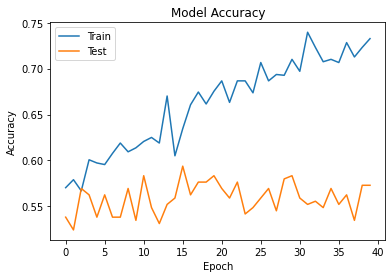

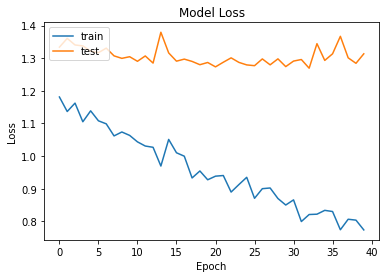

In [67]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

# Post-Model Analysis

In [68]:

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")


9/9 [==============================] - 0s 11ms/step - loss: 1.3136 - accuracy: 0.5729
Loss of the model is -  1.3135666847229004
9/9 [==============================] - 0s 11ms/step - loss: 1.3136 - accuracy: 0.5729
Accuracy of the model is -  57.29166865348816 %


In [70]:
# PREDICTIONS
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH 
finaldf = actual.join(predictions)
finaldf[140:150]

9/9 [==============================] - 0s 10ms/step


,Actual Values,Predicted Values
140,sad,calm
141,surprise,surprise
142,neutral,sad
143,sad,sad
144,fear,fear
145,sad,happy
146,disgust,disgust
147,angry,angry
148,surprise,happy
149,angry,angry


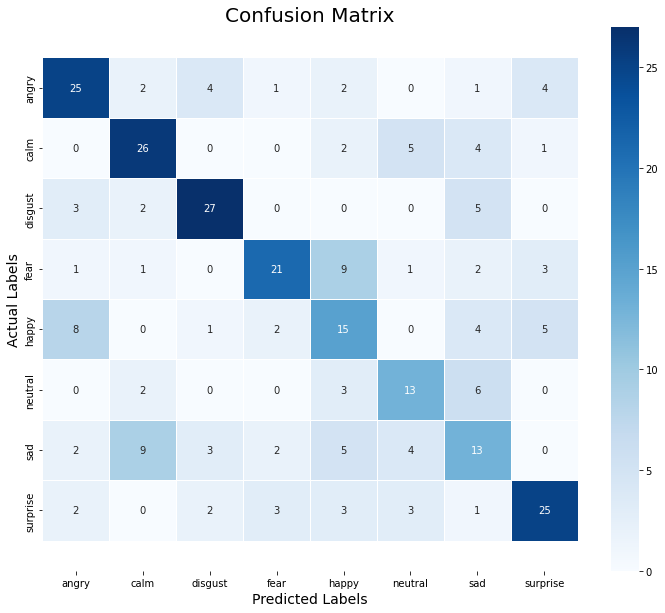

In [73]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [74]:
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))


              precision    recall  f1-score   support

       angry       0.61      0.64      0.62        39
        calm       0.62      0.68      0.65        38
     disgust       0.73      0.73      0.73        37
        fear       0.72      0.55      0.63        38
       happy       0.38      0.43      0.41        35
     neutral       0.50      0.54      0.52        24
         sad       0.36      0.34      0.35        38
    surprise       0.66      0.64      0.65        39

    accuracy                           0.57       288
   macro avg       0.57      0.57      0.57       288
weighted avg       0.58      0.57      0.57       288



In [75]:
## Hyperparameter Tuning
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['gender','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)


(1152, 259)
(288, 259)


In [76]:

# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


In [77]:

# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [78]:

# RESHAPE TO INCLUDE 3D TENSOR
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]


In [79]:
from keras.utils import np_utils, to_categorical

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\Users\asma0\anaconda3\envs\bean\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [83]:
# CREATE FUNCTION FOR KERAS CLASSIFIER
opt = keras.optimizers.Adam(lr=0.0001)
def make_classifier(optimizer=opt):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='sigmoid'))
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    return model


In [84]:
y_trainHot=np.argmax(y_train, axis=1)


In [85]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
classifier = KerasClassifier(build_fn = make_classifier)
params = {
    'batch_size': [30, 32, 34],
    'nb_epoch': [25, 50, 75],
    'optimizer':['adam','SGD']}

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5)

grid_search = grid_search.fit(X_train,y_trainHot)

C:\Users\asma0\AppData\Local\Temp\ipykernel_10500\1534782901.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = make_classifier)


39/39 [==============================] - 2s 43ms/step - loss: 2.8387 - accuracy: 0.1979


In [86]:
grid_search.best_params_


{'batch_size': 30, 'nb_epoch': 75, 'optimizer': 'adam'}

In [87]:

grid_search.best_score_


0.2647581404103143